Представим, что мы работаем аналитиком в очень крупной компании по доставке пиццы над приложением для курьеров (да, обычно в таких компаниях есть приложение для курьеров и отдельно приложение для потребителей).

У нас есть несколько ресторанов в разных частях города и целый штат курьеров. Но есть одна проблема — к вечеру скорость доставки падает из-за того, что курьеры уходят домой после рабочего дня, а количество заказов лишь растет. Это приводит к тому, что в момент пересмены наша доставка очень сильно проседает в эффективности. 

Наши data scientist-ы придумали новый алгоритм, который позволяет курьерам запланировать свои последние заказы перед окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. То есть, чтобы курьеры доставляли последние свои заказы за день как бы "по пути" домой. 

Мы вместе с командой решили раскатить A/B тест на две равные группы курьеров. Часть курьеров использует старый алгоритм без опции "по пути", другие видят в своем приложении эту опцию и могут ее выбрать. Наша задача – проанализировать данные эксперимента и помочь бизнесу принять решение о раскатке новой фичи на всех курьеров.

Описание данных

- order_id - id заказа

- delivery_time - время доставки в минутах

- district - район доставки

- experiment_group - экспериментальная группа

In [30]:
import pandas as pd
import numpy as np
import scipy 
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
import scipy.stats as st

In [2]:
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

In [3]:
data = pd.read_csv('C:/Users/1/JupyterProjects/Karpov_courses_lessons_and_projects/module_statistics/all_data/experiment_lesson_4.csv')

In [4]:
data.head()

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20196 entries, 0 to 20195
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          20196 non-null  int64  
 1   delivery_time     20196 non-null  float64
 2   district          20196 non-null  object 
 3   experiment_group  20196 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 631.2+ KB


Сформируем гипотезы для проверки:

- Нулевая гипотеза (H0): Разницы между средним временем доставки в тестовой и контрольной группе нет

- Альтернативная гипотеза (H1): Разница между средним временем доставки в тестовой и контрольной группе есть

Text(0.5, 1.0, 'control')

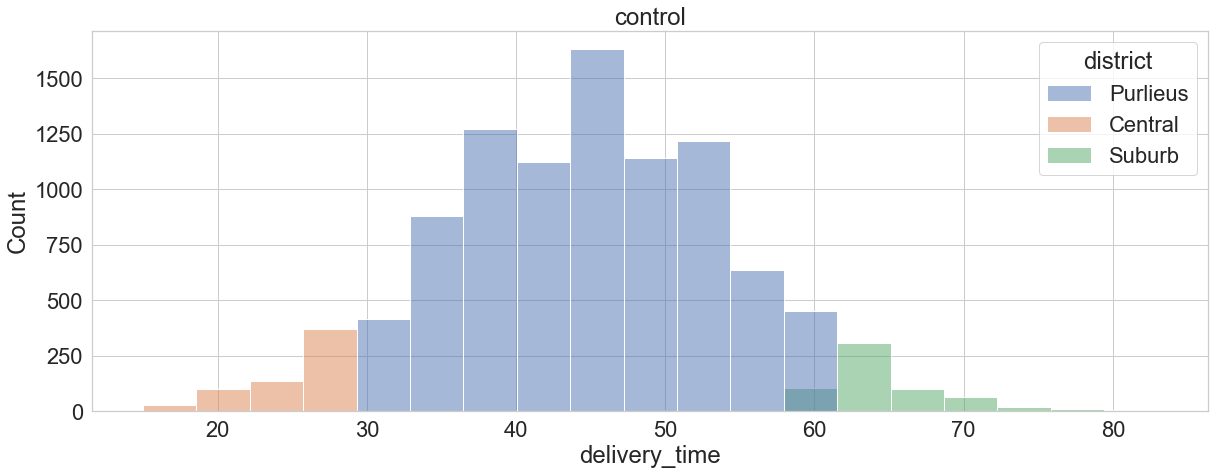

In [6]:
fig, ax = plt.subplots()
sns.histplot(data=data.query('experiment_group == "control"'), x='delivery_time', hue='district', bins=19)
ax.set_title('control')

Text(0.5, 1.0, 'test')

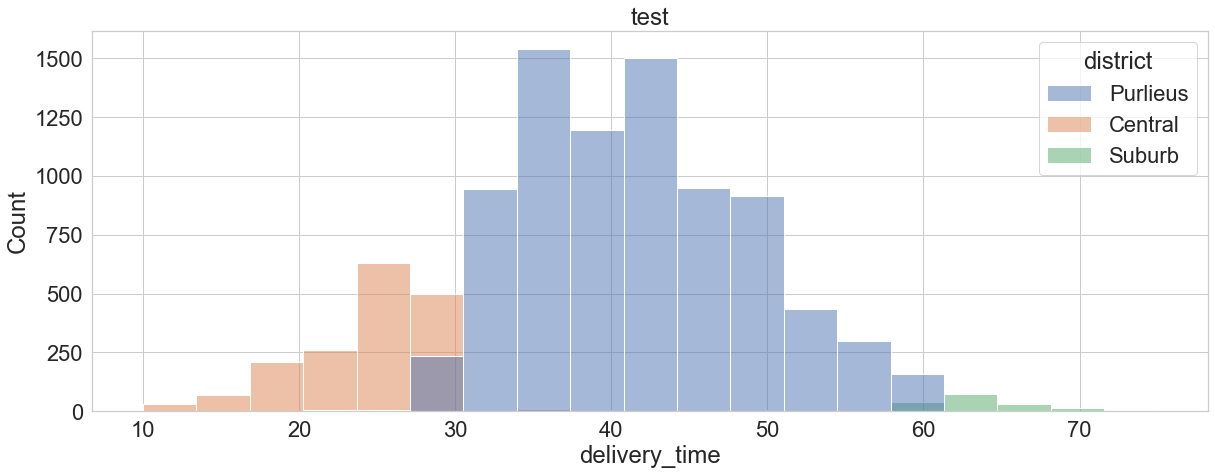

In [7]:
fig, ax = plt.subplots()
sns.histplot(data=data.query('experiment_group == "test"'), x='delivery_time', hue='district', bins=19)
ax.set_title('test')

Количество наблюдений в группах:

In [21]:
data.groupby('experiment_group').size()

experiment_group
control    10092
test       10104
dtype: int64

Теперь давайте изучим наши распределения. Проверим выполнение условий на нормальность и посчитаем стандартное отклонение в тесте и в контроле:

In [22]:
# Тест
data_test = data.query('experiment_group == "test"').delivery_time

In [11]:
# используем normaltest(тест Агостино-Пирсона), он больше адаптирован к большим выборкам, чем shapiro
scipy.stats.normaltest(data_test)

NormaltestResult(statistic=7.024157092641915, pvalue=0.02983483685333173)

<AxesSubplot:xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

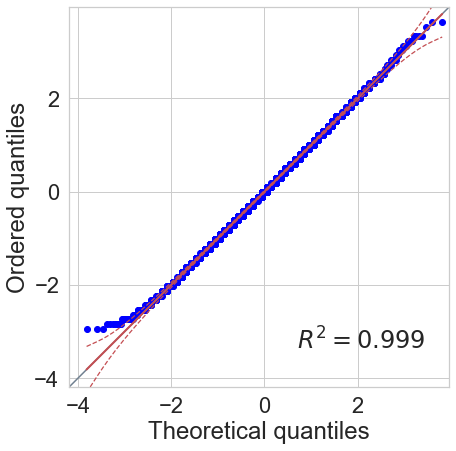

In [25]:
pg.qqplot(data_test)

In [26]:
np.std(data_test)

9.882819260031342

In [14]:
# Контроль
data_control = data.query('experiment_group == "control"').delivery_time

In [15]:
scipy.stats.normaltest(data_control)

NormaltestResult(statistic=0.25349755437872584, pvalue=0.8809549607809654)

In [27]:
np.std(data_control)

9.989522000652327

<AxesSubplot:xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

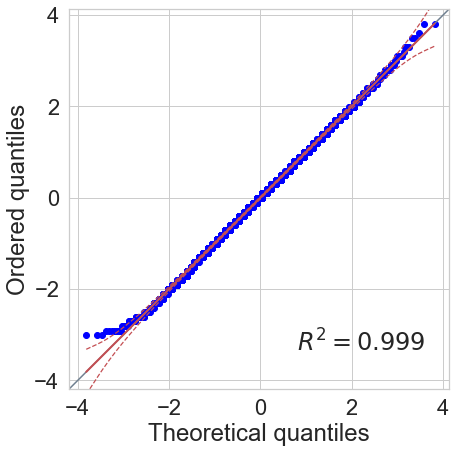

In [28]:
pg.qqplot(data_control)

Небольшие отклонения от нормальности есть, но на такого размера выборках мы все еще можем полагаться на t-test

Применим t-критерий Стьюдента

In [18]:
scipy.stats.ttest_ind(data_test, data_control)

Ttest_indResult(statistic=-43.03582663183714, pvalue=0.0)

In [29]:
pg.ttest(data_test, data_control)

C:\Users\1\AppData\Local\Programs\Python\Python310\lib\site-packages\pingouin\bayesian.py:152: RuntimeWarning: divide by zero encountered in scalar divide
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-43.035552,20191.127788,two-sided,0.0,"[-6.29, -5.74]",0.605658,inf,1.0


In [32]:
# Yuen t-test (отрезает некоторое количество наблюдений с каждой стороны распределения)
st.ttest_ind(data_test, data_control, trim=0.2)

Ttest_indResult(statistic=-42.16055367343425, pvalue=0.0)

In [34]:
# permutation test
st.ttest_ind(data_test, data_control, permutations=1000)

Ttest_indResult(statistic=-43.03582663183714, pvalue=0.0)

Получаем статзначимые различия

In [19]:
(data_test.mean() - data_control.mean()) * 100 / data_control.mean()

-13.354653121660812

Вывод: такую функцию можно вводить в использование для всех пользователей, так как среднее время доставки статзначимо изменилось. Среднее время доставки в тесте меньше, чем в контроле.